In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_color_mask(self, imghsv, color_ranges):
    mask = np.zeros(imghsv.shape[:2], dtype=np.uint8)
    for lower, upper in color_ranges:
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        color_mask = cv2.inRange(imghsv, lower, upper)
        mask = cv2.bitwise_or(mask, color_mask)
    return mask

In [3]:
def is_field_shape(self, field_mask, maxcont):
    score = 0
    
    # CRITERION 1: SQUARENESS
    _, _, w, h = cv2.boundingRect(maxcont)
    if 0.75 <= (aspratio := w / h) <= 1.5:
        score += 2
    else:
        score -= 2

    # CRITERION 2: SOLIDITY
    area = cv2.contourArea(maxcont)
    hullarea = cv2.contourArea(cv2.convexHull(maxcont))
    if (solidity := area / hullarea if hullarea > 0 else 0) < 0.85:
        score += 1

    # CRITERION 3: EXTENT
    rectarea = w * h
    if (extent := area / rectarea if rectarea > 0 else 0) < 0.7:
        score += 1

    # CRITERION 4: CIRCULARITY
    perimeter = cv2.arcLength(maxcont, True)
    if (circularity := 4 * np.pi * area / perimeter ** 2 if perimeter > 0 else 0) > 0.6:
        score += 1

    return score >= 3

In [4]:
def is_field_color(self, field_mask, dirts_mask):
    score = 0
    pixels = np.count_nonzero(field_mask)
    dirt = np.count_nonzero(cv2.bitwise_and(dirts_mask, field_mask))
    if 0.15 <= (ratio := dirt / pixels if pixels > 0 else 0) <= 0.5:
        score += 2
    elif ratio < 0.05:
        score -= 2
    elif ratio > 0.6:
        score -= 1
    if dirt == 0:
        return score > 0
    contours, _ = cv2.findContours(dirts_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return score > 0
    maxcont = max(contours, key=cv2.contourArea)
    if cv2.contourArea(maxcont) > 1000:
        score += 1
    return score > 0

In [5]:
def isolate_field(self, grass_mask, dirts_mask):
    mask = cv2.bitwise_or(grass_mask, dirts_mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("ISOLATE FIELD: NO CONTOURS FOUND")
        return None
    if cv2.contourArea(maxcont := max(contours, key=cv2.contourArea)) < 5000:
        print("ISOLATE FIELD: AREA TOO SMALL")
        return None
    field_mask = np.zeros_like(mask)
    cv2.drawContours(field_mask, [maxcont], -1, 255, -1)
    if not self.is_field_shape(field_mask, maxcont):
        print("ISOLATE FIELD: NOT FIELD SHAPED")
        return None
    if not self.is_field_color(field_mask, dirts_mask):
        print("ISOLATE FIELD: NOT FIELD COLORED")
        return None
    return field_mask

In [6]:
def detect_field_lines(self, img, field_mask):
    maskedimg = cv2.bitwise_and(img, img, mask=field_mask)
    gray = cv2.cvtColor(maskedimg, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, threshold=80,
        minLineLength=60, maxLineGap=10
    )
    return edges, lines

In [7]:
def filter_lines(self, lines, field_mask):
    filtlines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1)) % 180
        if length < 40:
            continue
        if 0 <= angle <= 10 or 80 <= angle <= 100 or 170 <= angle <= 180:
            continue
        filtlines.append({
            "coords": line[0], "angle": angle,
            "length": length, "center": (cx, cy)
        })
    return filtlines

In [8]:
def find_intersection(self, line1, line2):
    (x1, y1, x2, y2), (x3, y3, x4, y4) = line1, line2
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if abs(denom) < 1e-10:
        return None
    t =  ((x1 - x3) * (y3 - y4) - (y1 - y2) * (x3 - x4)) / denom
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom
    if 0 <= t <= 1 and 0 <= u <= 1:
        return int(x1 + t * (x2 - x1)), int(y1 + t * (y2 - y1))
    else:
        return None

In [9]:
def get_direction_away(self, line_coords, point):
    (x1, y1, x2, y2), (px, py) = line_coords, point
    d1 = np.sqrt((x1 - px) ** 2 + (y1 - py) ** 2)
    d2 = np.sqrt((x2 - px) ** 2 + (y2 - py) ** 2)
    if d1 < d2:
        return np.degrees(np.arctan2(y2 - y1, x2 - x1)) % 360
    else:
        return np.degrees(np.arctan2(y1 - y2, x1 - x2)) % 360

In [10]:
def consistent_direction_away(self, line1, line2, point):
    d1 = self.get_direction_away(line1["coords"], point)
    d2 = self.get_direction_away(line2["coords"], point)
    angbisect = (d1 + d2) / 2
    diff1 = min(abs(d1 - angbisect), 360 - abs(d1 - angbisect))
    diff2 = min(abs(d2 - angbisect), 360 - abs(d2 - angbisect))
    return abs(diff1 - diff2) < 30

In [11]:
def identify_corners(self, lines):
    corners = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            l1, l2 = lines[i], lines[j]
            isect = self.find_intersection(l1["coords"], l2["coords"])
            if not isect:
                continue
            angle_diff = abs(l1["angle"] - l2["angle"])
            angle_diff = min(angle_diff, 180 - angle_diff)
            if 80 <= angle_diff <= 100:
                corners.append({
                    "point": isect, "lines": (l1, l2),
                    "angle_diff": angle_diff, "pos_score": 0
                })
    return corners

In [12]:
def score_corners(self, corners, field_center):
    for corner in corners:
        (ix, iy), (l1, l2) = corner["point"], corner["lines"]
        d1 = self.get_direction_away(l1["coords"], (ix, iy))
        d2 = self.get_direction_away(l2["coords"], (ix, iy))
        angbisect = (d1 + d2) / 2
        angcenter = np.degrees(np.arctan2(field_center[1] - iy, field_center[0] - ix))
        angdiff = abs(angbisect - angcenter)
        angdiff = min(angdiff, 360 - angdiff)
        
        # CRITERION 1: FIELD CENTER DIRECTION
        if angdiff < 45:
            corner["pos_score"] += 2

        # CRITERION 2: FOUL LINES SAME LENGTH
        if min(l1["length"], l2["length"]) / max(l1["length"], l2["length"]) > 0.7:
            corner["pos_score"] += 1

        # CRITERION 3: CONSISTENT DIRECTION AWAY
        if self.consistent_direction_away(l1, l2, (ix, iy)):
            corner["pos_score"] += 1
    return corners

In [13]:
def identify_home_plate(self, lines, field_mask):
    field_center = np.array(field_mask.shape) // 2
    corners = self.identify_corners(lines)
    if not corners:
        return None, None
    corners = self.score_corners(corners, field_center)
    best = max(corners, key = lambda x: x["pos_score"])
    return best["point"], best["lines"]

In [14]:
def visualize(self, image, home_plate, foul_lines, field_mask, grass_mask, dirts_mask):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # DRAW FIELD BOUNDARY
    img = image.copy()
    contours, _ = cv2.findContours(field_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (255, 255, 0), 2)
    axs[0, 0].imshow(img)
    axs[0, 0].set(title="Field Boundary")
    axs[0, 0].axis("off")

    # DRAW HOME PLATE
    # img = image.copy()
    # if home_plate and foul_lines:
    #     (l1, l2), (px, py) = foul_lines, home_plate
    #     for i, line in enumerate([l1, l2]):
    #         x1, y1, x2, y2 = line['coords']
    #         d1 = np.sqrt((x1 - px) **2 + (y1 - py) **2)
    #         d2 = np.sqrt((x2 - px) **2 + (y2 - py) **2)
    #         if d1 < d2:
    #             cv2.line(
    #                 img, (x1, y1), (x2, y2),
    #                 (255, 0, 0) if i == 0 else (0, 255, 0), 4
    #             )
    #             cv2.arrowedLine(
    #                 img, (x1, y1), (x2, y2),
    #                 (255, 0, 0) if i == 0 else (0, 255, 0), 2, tipLength=0.1
    #             )
    #         else:
    #             cv2.line(
    #                 img, (x1, y1), (x2, y2),
    #                 (255, 0, 0) if i == 0 else (0, 255, 0), 4
    #             )
    #             cv2.arrowedLine(
    #                 img, (x2, y2), (x1, y1),
    #                 (255, 0, 0) if i == 0 else (0, 255, 0), 2, tipLength=0.1
    #             )
    #     cv2.circle(img, home_plate, 12, (0, 0, 255), -1)
    #     cv2.putText(
    #         img, "HOME PLATE", (home_plate[0] + 15, home_plate[1]), 
    #         cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2
    #     )
    # axs1[1].imshow(img)
    # axs1[1].set(title="Home Plate")
    # axs1[1].axis("off")

    for axs, mask, title in zip(axs.ravel()[1:],
        [field_mask, grass_mask, dirts_mask],
        ["Field Mask", "Grass Mask", "Dirt Mask"]
    ):
        axs.imshow(mask, cmap="Greys")
        axs.set(title=title)
        axs.axis("off")

    plt.tight_layout()
    plt.show()

In [15]:
def detect_baseball_diamond(self, imgpath):
    img = cv2.imread(imgpath)
    imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imghsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    grass_mask = self.create_color_mask(imghsv, self.grass_ranges)
    dirts_mask = self.create_color_mask(imghsv, self.dirts_ranges)
    field_mask = self.isolate_field(grass_mask, dirts_mask)
    if field_mask is None:
        print("NO BASEBALL FIELD DETECTED")
        return
    edges, lines = self.detect_field_lines(imgrgb, field_mask)
    lines = self.filter_lines(lines, field_mask)
    home_plate, foul_lines = self.identify_home_plate(lines, field_mask)
    self.visualize(imgrgb, home_plate, foul_lines, field_mask, grass_mask, dirts_mask)
    return home_plate, foul_lines

In [16]:
class BaseballDetector:
    def __init__(self):
        self.grass_ranges = [((35, 40, 40), (85, 255, 255))]
        self.dirts_ranges = [(( 0, 30, 30), (25, 200, 200))]

BaseballDetector.create_color_mask         = create_color_mask
BaseballDetector.is_field_shape            = is_field_shape
BaseballDetector.is_field_color            = is_field_color
BaseballDetector.isolate_field             = isolate_field
BaseballDetector.detect_field_lines        = detect_field_lines
BaseballDetector.filter_lines              = filter_lines
BaseballDetector.find_intersection         = find_intersection
BaseballDetector.get_direction_away        = get_direction_away
BaseballDetector.consistent_direction_away = consistent_direction_away
BaseballDetector.identify_corners          = identify_corners
BaseballDetector.score_corners             = score_corners
BaseballDetector.identify_home_plate       = identify_home_plate
BaseballDetector.detect_baseball_diamond   = detect_baseball_diamond
BaseballDetector.visualize                 = visualize

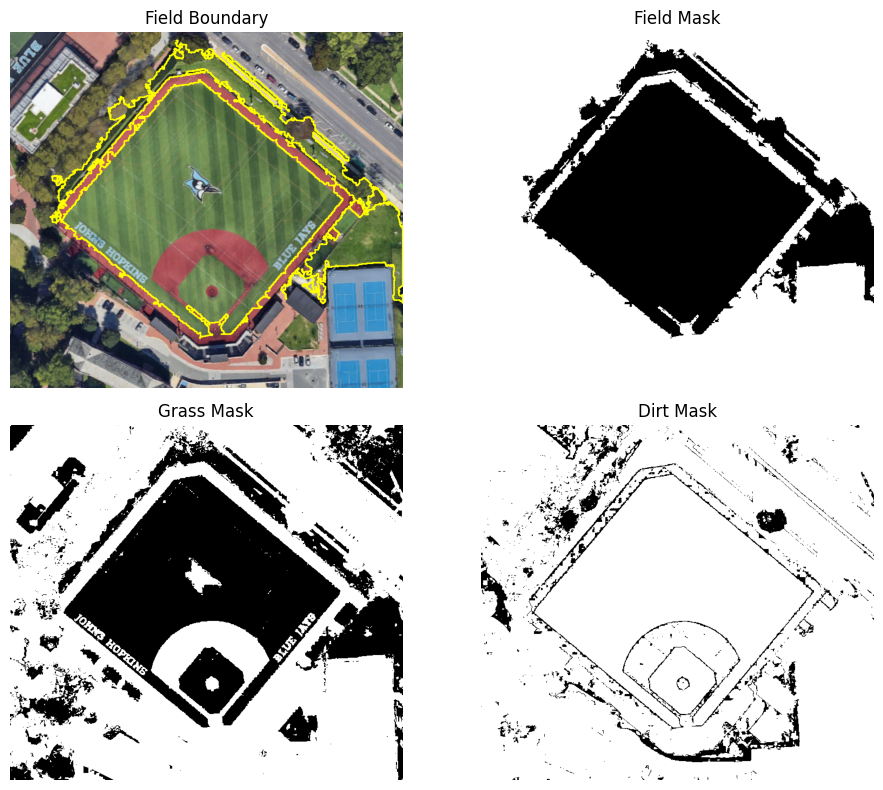

((619, 376),
 ({'coords': array([541, 470, 644, 347], dtype=int32),
   'angle': np.float64(129.94275146744087),
   'length': np.float64(160.4306703844374),
   'center': (np.float64(592.5), np.float64(408.5))},
  {'coords': array([584, 262, 676, 340], dtype=int32),
   'angle': np.float64(40.292147755627774),
   'length': np.float64(120.61509026651682),
   'center': (np.float64(630.0), np.float64(301.0))}))

In [17]:
detector = BaseballDetector()
detector.detect_baseball_diamond("baseball.png")

In [18]:
detector.detect_baseball_diamond("football.png")

ISOLATE FIELD: NOT FIELD COLORED
NO BASEBALL FIELD DETECTED


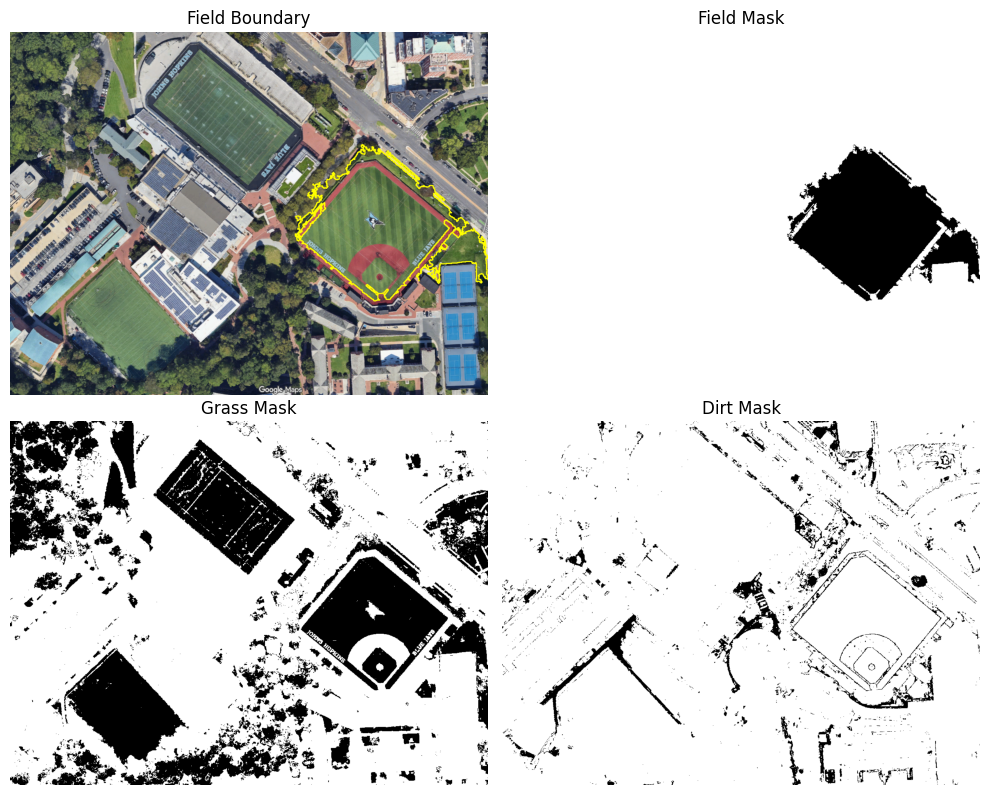

((1080, 429),
 ({'coords': array([1024,  373, 1091,  440], dtype=int32),
   'angle': np.float64(45.0),
   'length': np.float64(94.75230867899737),
   'center': (np.float64(1057.5), np.float64(406.5))},
  {'coords': array([1072,  540, 1128,  473], dtype=int32),
   'angle': np.float64(129.88958243896877),
   'length': np.float64(87.32124598286491),
   'center': (np.float64(1100.0), np.float64(506.5))}))

In [19]:
detector.detect_baseball_diamond("combined.png")